<a class="anchor" id="top"></a>

** **

# 1. Importing Libraries & Data
In this section, we set up the foundation for our project by importing the necessary Python libraries and loading the dataset. These libraries provide the tools for data manipulation, visualization, and machine learning modeling throughout the notebook. Additionally, we import the historical claims dataset, which forms the core of our analysis. 

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Train-Test Split
from sklearn.model_selection import train_test_split

import preproc as p

# fs
from sklearn.feature_selection import VarianceThreshold
import feature_selection as fs
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PowerTransformer

pd.set_option('display.max_columns', None)
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

**Import Data**

In [85]:
# Load training data
df = pd.read_csv('train_data_EDA.csv', index_col = 'Claim Identifier')

# Load testing data
test = pd.read_csv('test_data_EDA.csv', index_col = 'Claim Identifier')

# Display the first 3 rows of the training data
df.head(3)

,Age at Injury,Average Weekly Wage,Birth Year,Claim Injury Type,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Alternative Dispute Resolution Bin,Attorney/Representative Bin,Carrier Name Enc,Carrier Type freq,Carrier Type_1A. PRIVATE,Carrier Type_2A. SIF,Carrier Type_3A. SELF PUBLIC,Carrier Type_4A. SELF PRIVATE,County of Injury freq,COVID-19 Indicator Enc,District Name freq,Gender Enc,Gender_F,Gender_M,Medical Fee Region freq,Accident Date Year,Accident Date Month,Accident Date Day,Accident Date Day of Week,Assembly Date Year,Assembly Date Month,Assembly Date Day,Assembly Date Day of Week,C-2 Date Year,C-2 Date Month,C-2 Date Day,C-2 Date Day of Week,WCIO Codes,Insurance,Zip Code Valid,Industry Sector Count Enc,Age Group,C-3 Date Binary,First Hearing Date Binary
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393875,31.0,0.00,1988.0,1,0.0,44.0,27,10,62,1.0,0,0,399,285367,1,0,0,0,3355,0,44646,0,0,1,135885,2019.0,12.0,30.0,0.0,2020,1,1,2,2019.0,12.0,31.0,1.0,271062,1,0,103330,1,0,0
5393091,46.0,1745.93,1973.0,3,4.0,23.0,97,49,38,4.0,0,1,1023,285367,1,0,0,0,760,0,40449,1,1,0,135885,2019.0,8.0,30.0,4.0,2020,1,1,2,2020.0,1.0,1.0,2.0,974938,1,0,69053,1,1,1
5393889,40.0,1434.80,1979.0,3,0.0,56.0,79,7,10,6.0,0,0,689,285367,1,0,0,0,17450,0,86171,0,0,1,85033,2019.0,12.0,6.0,4.0,2020,1,1,2,2020.0,1.0,1.0,2.0,79710,1,0,57495,1,0,0


# 2. Train-Test Split
The train-test split is a crucial technique used to assess model performance by dividing the dataset into training and testing subsets. This ensures that the model is evaluated on unseen data, helping to prevent overfitting and providing an unbiased performance estimate. 

<a href="#top">Top &#129033;</a>

**Holdout Method**

In [86]:
# Split the DataFrame into features (X) and target variable (y)
X = df.drop('Claim Injury Type', axis=1)
y = df['Claim Injury Type']

In [87]:
print(X.isnull().sum())  # Check missing values in features
print(y.isnull().sum())  # Check missing values in the target variable

Age at Injury                             0
Average Weekly Wage                   28651
Birth Year                            29078
IME-4 Count                               0
Industry Code                             0
WCIO Cause of Injury Code                 0
WCIO Nature of Injury Code                0
WCIO Part Of Body Code                    0
Number of Dependents                      0
Alternative Dispute Resolution Bin        0
Attorney/Representative Bin               0
Carrier Name Enc                          0
Carrier Type freq                         0
Carrier Type_1A. PRIVATE                  0
Carrier Type_2A. SIF                      0
Carrier Type_3A. SELF PUBLIC              0
Carrier Type_4A. SELF PRIVATE             0
County of Injury freq                     0
COVID-19 Indicator Enc                    0
District Name freq                        0
Gender Enc                                0
Gender_F                                  0
Gender_M                        

In [88]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y) 

# 3. Missing Values

<a href="#top">Top &#129033;</a>

In [89]:
X_train.isna().sum()

Age at Injury                             0
Average Weekly Wage                   22968
Birth Year                            23204
IME-4 Count                               0
Industry Code                             0
WCIO Cause of Injury Code                 0
WCIO Nature of Injury Code                0
WCIO Part Of Body Code                    0
Number of Dependents                      0
Alternative Dispute Resolution Bin        0
Attorney/Representative Bin               0
Carrier Name Enc                          0
Carrier Type freq                         0
Carrier Type_1A. PRIVATE                  0
Carrier Type_2A. SIF                      0
Carrier Type_3A. SELF PUBLIC              0
Carrier Type_4A. SELF PRIVATE             0
County of Injury freq                     0
COVID-19 Indicator Enc                    0
District Name freq                        0
Gender Enc                                0
Gender_F                                  0
Gender_M                        

**Birth Year**

To fill the missing values, we will start by creating a mask, which filters for observations where **Age at Injury** and **Accident Date Year** are not missing, and when **Birth Year** is either missing or zero. Since we are going to use **Age at Injury** and **Accident Date Year** to compute **Birth Year**, ensuring those two variables are no missing is crucial. Then, we also decided to recompute the **Birth Year** where it is 0, since it is impossible to have 0 as a **Birth Year**.

In [90]:
train_mask = X_train['Accident Date Year'].notna() & X_train['Age at Injury'].notna() & \
           (X_train['Birth Year'].isna() | (X_train['Birth Year'] == 0))


val_mask = (X_val['Accident Date Year'].notna() &  X_val['Age at Injury'].notna() &  
    (X_val['Birth Year'].isna() | (X_val['Birth Year'] == 0)))

test_mask = test['Accident Date Year'].notna() & test['Age at Injury'].notna() & \
           (test['Birth Year'].isna() | (test['Birth Year'] == 0))

In [91]:
X_train.loc[train_mask, 'Birth Year'] = X_train['Accident Date Year'] - X_train['Age at Injury']

X_val.loc[val_mask, 'Birth Year'] = X_val['Accident Date Year'] - X_val['Age at Injury']

test.loc[test_mask, 'Birth Year'] = test['Accident Date Year'] - test['Age at Injury']

**Average Weekly Wage**

In [92]:
X_train['Average Weekly Wage'] = p.ball_tree_impute(X_train, 'Average Weekly Wage', n_neighbors=100)

X_val['Average Weekly Wage'] = p.ball_tree_impute(X_val, 'Average Weekly Wage', n_neighbors=100)

test['Average Weekly Wage'] = p.ball_tree_impute(test, 'Average Weekly Wage', n_neighbors=100)

ValueError: Input X contains NaN.
NearestNeighbors does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# 3. Outliers

<a href="#top">Top &#129033;</a>

### Outlier Detection

To detect outliers we will use a function that plots boxplots and identifies outliers based on the Interquartile Range method. This function will also add to a list all columns with a higher percentage of outliers than a previously set threshold.

Column: Age at Injury - Number of Outliers: 165
Column: Age at Injury - % of Outliers: 0.04% 



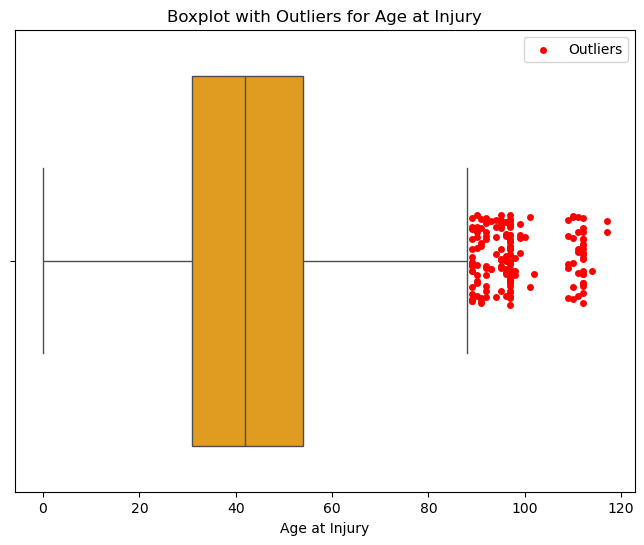

Column: Average Weekly Wage - Number of Outliers: 17711
Column: Average Weekly Wage - % of Outliers: 3.86% 



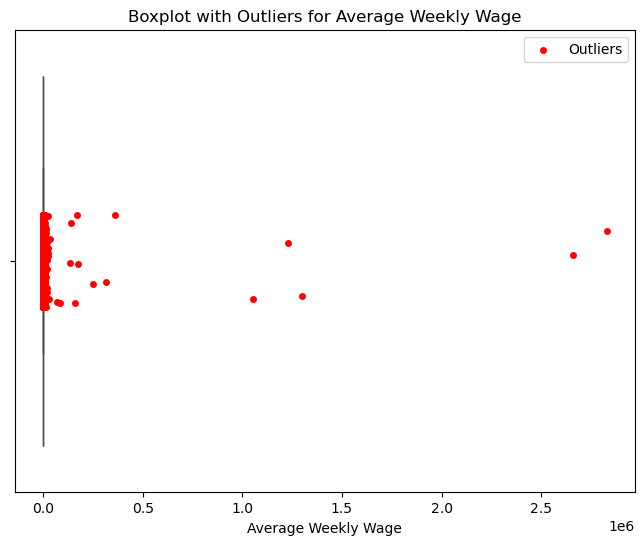

Column: Birth Year - Number of Outliers: 498
Column: Birth Year - % of Outliers: 0.11% 



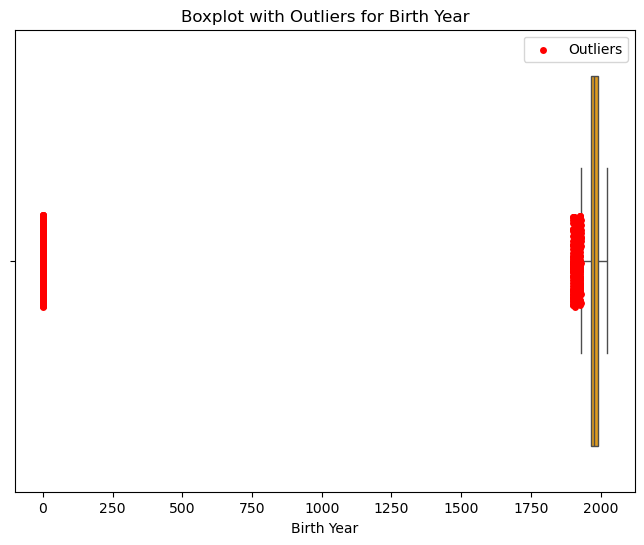

Column: IME-4 Count - Number of Outliers: 106210
Column: IME-4 Count - % of Outliers: 23.13% 



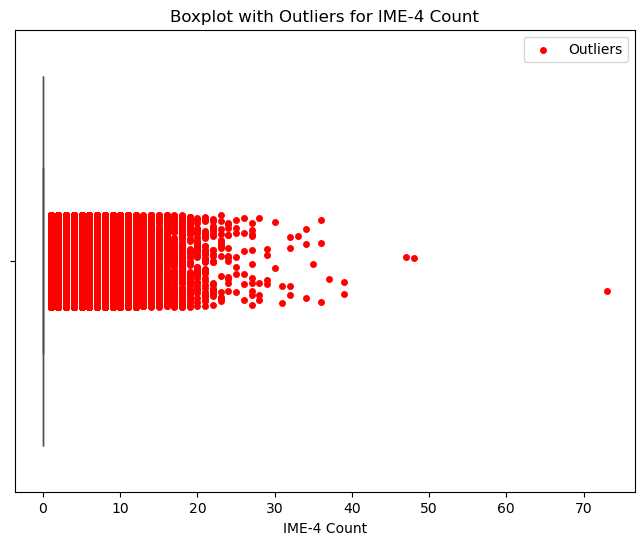

Column: Industry Code - Number of Outliers: 83608
Column: Industry Code - % of Outliers: 18.21% 



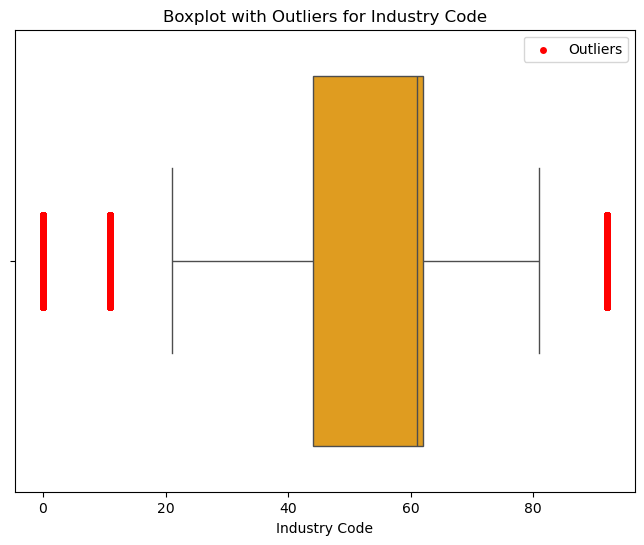

Column: WCIO Cause of Injury Code - Number of Outliers: 0
Column: WCIO Cause of Injury Code - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


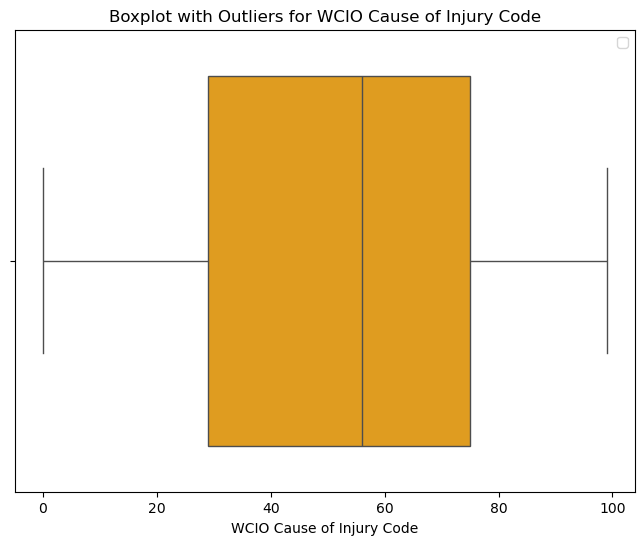

Column: WCIO Nature of Injury Code - Number of Outliers: 0
Column: WCIO Nature of Injury Code - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


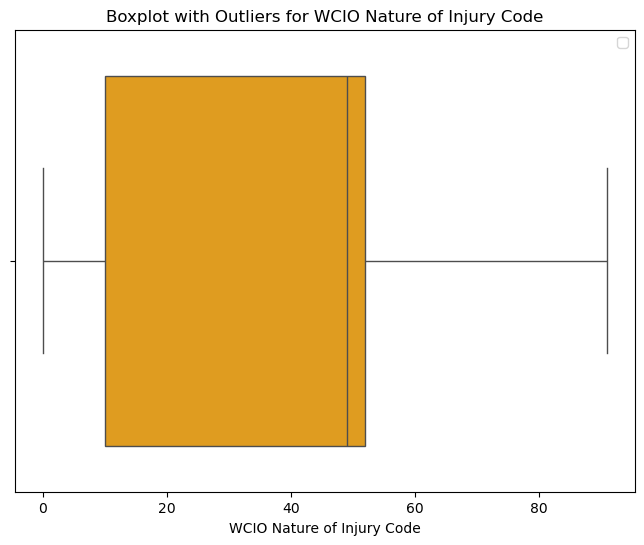

Column: WCIO Part Of Body Code - Number of Outliers: 41536
Column: WCIO Part Of Body Code - % of Outliers: 9.04% 



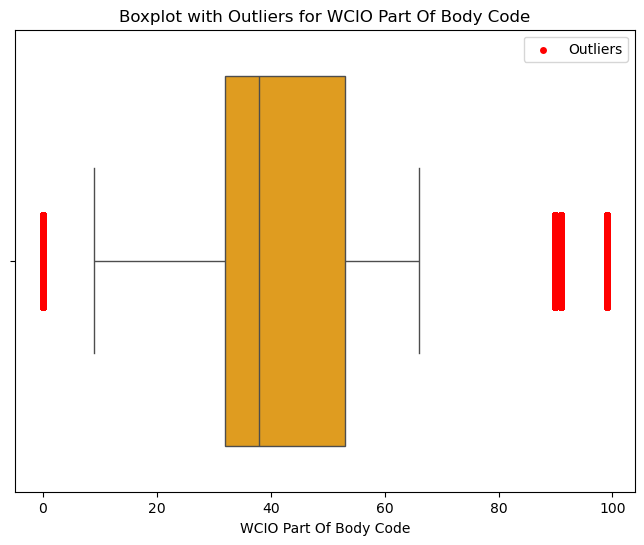

Column: Number of Dependents - Number of Outliers: 0
Column: Number of Dependents - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


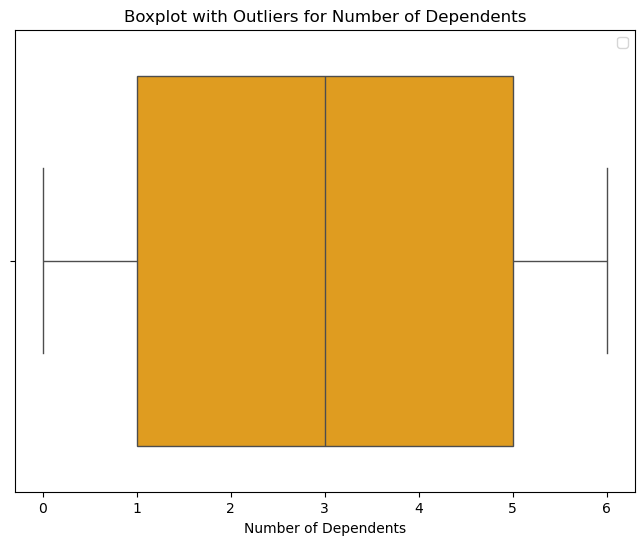

Column: Alternative Dispute Resolution Bin - Number of Outliers: 2073
Column: Alternative Dispute Resolution Bin - % of Outliers: 0.45% 



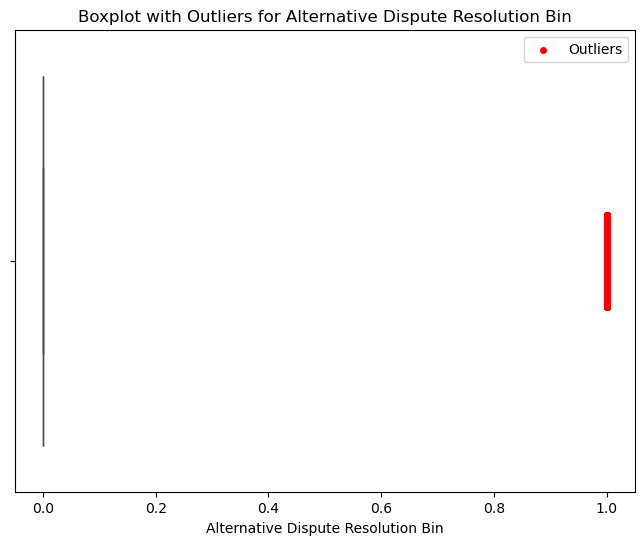

Column: Attorney/Representative Bin - Number of Outliers: 0
Column: Attorney/Representative Bin - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


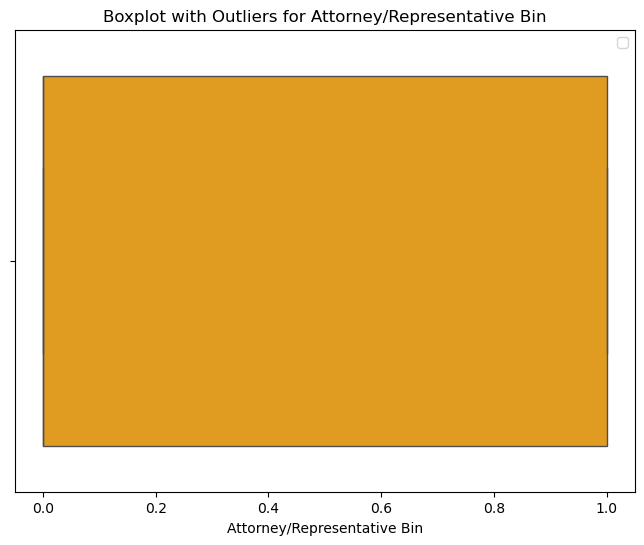

Column: Carrier Name Enc - Number of Outliers: 0
Column: Carrier Name Enc - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


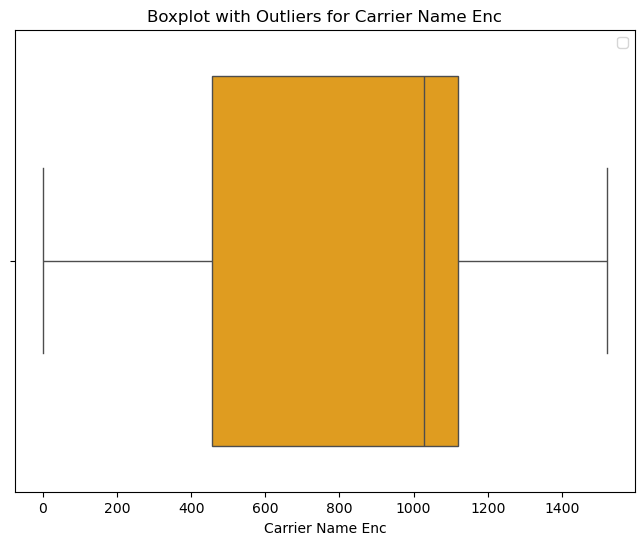

Column: Carrier Type freq - Number of Outliers: 0
Column: Carrier Type freq - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


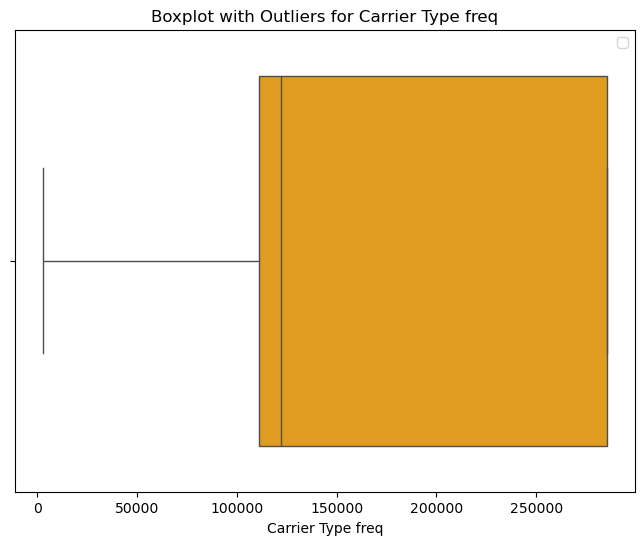

Column: Carrier Type_1A. PRIVATE - Number of Outliers: 0
Column: Carrier Type_1A. PRIVATE - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


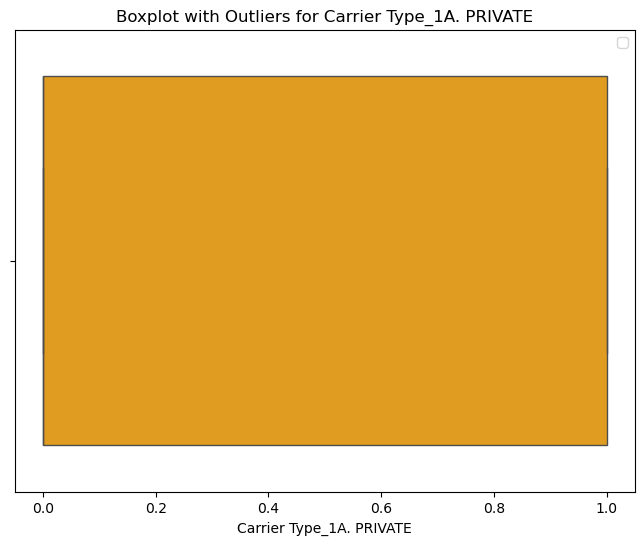

Column: Carrier Type_2A. SIF - Number of Outliers: 88880
Column: Carrier Type_2A. SIF - % of Outliers: 19.35% 



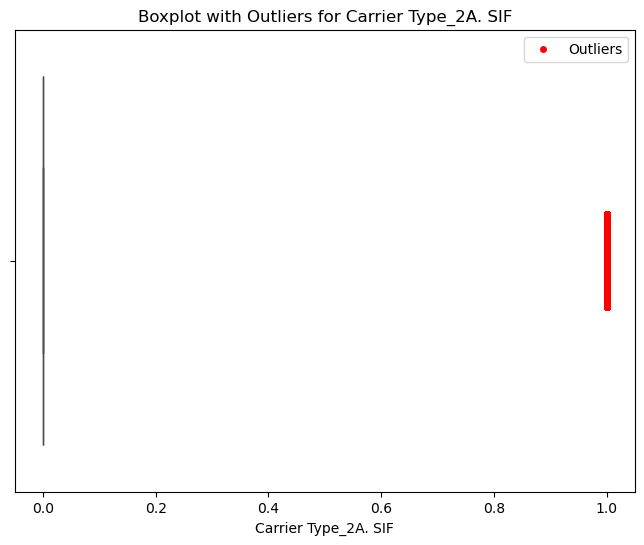

Column: Carrier Type_3A. SELF PUBLIC - Number of Outliers: 97437
Column: Carrier Type_3A. SELF PUBLIC - % of Outliers: 21.22% 



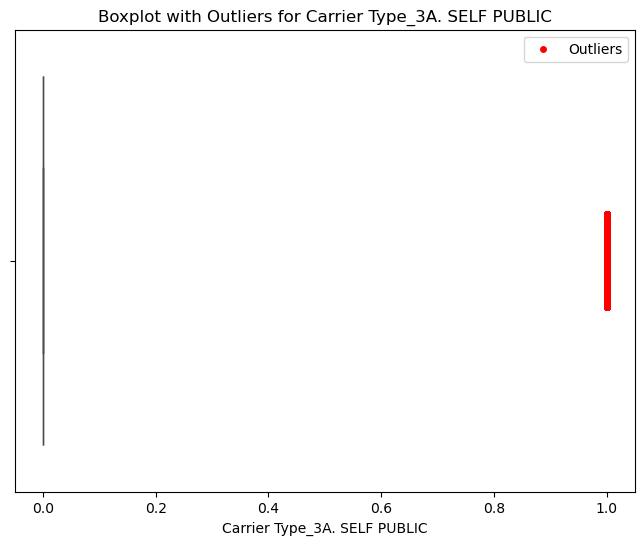

Column: Carrier Type_4A. SELF PRIVATE - Number of Outliers: 42176
Column: Carrier Type_4A. SELF PRIVATE - % of Outliers: 9.18% 



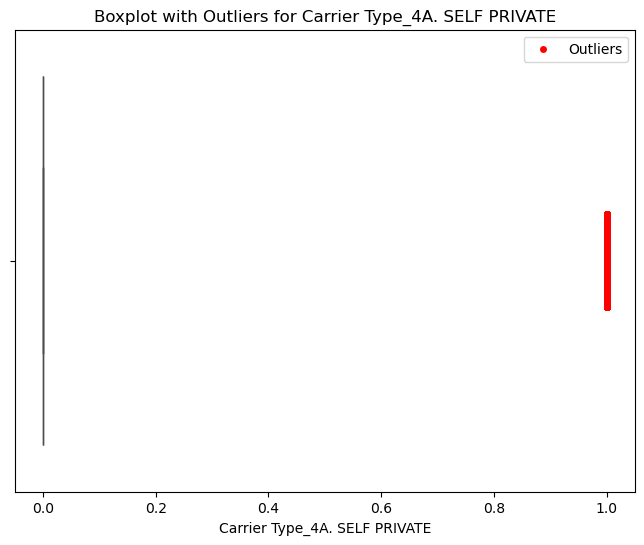

Column: County of Injury freq - Number of Outliers: 0
Column: County of Injury freq - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


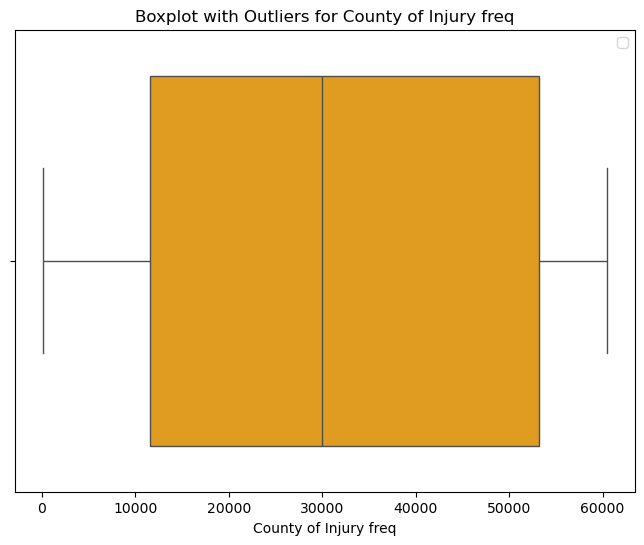

Column: COVID-19 Indicator Enc - Number of Outliers: 22096
Column: COVID-19 Indicator Enc - % of Outliers: 4.81% 



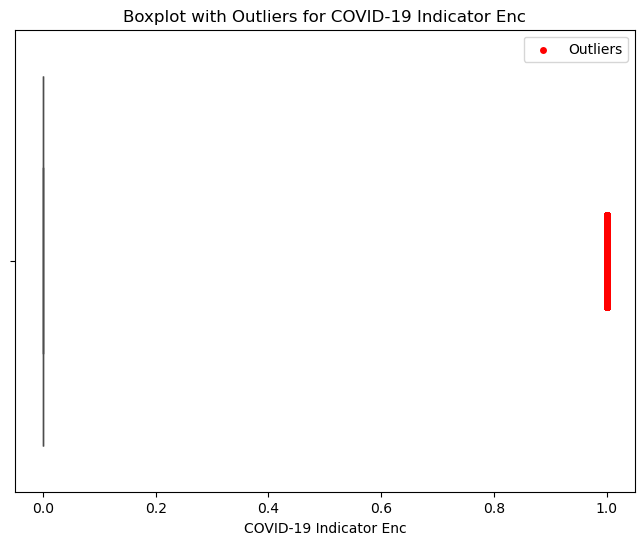

Column: District Name freq - Number of Outliers: 0
Column: District Name freq - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


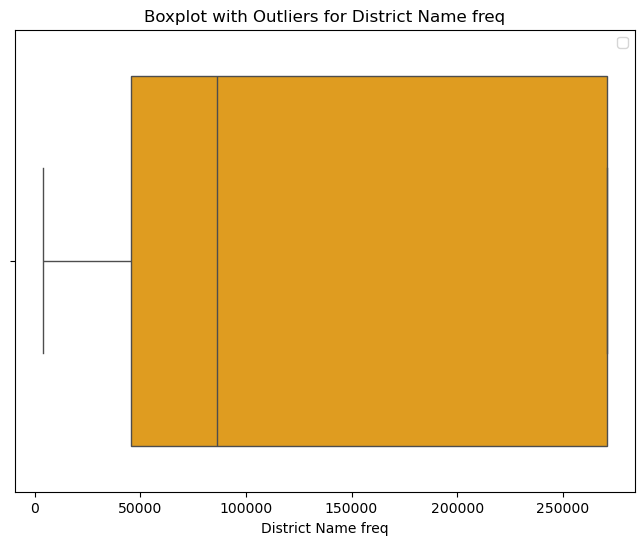

Column: Gender Enc - Number of Outliers: 0
Column: Gender Enc - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


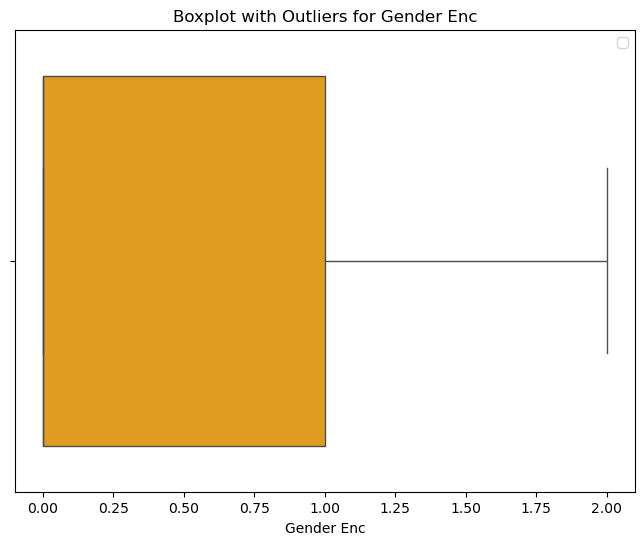

Column: Gender_F - Number of Outliers: 0
Column: Gender_F - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


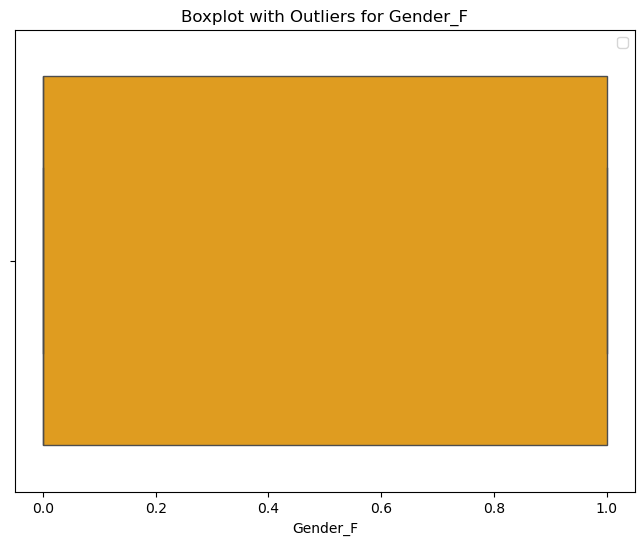

Column: Gender_M - Number of Outliers: 0
Column: Gender_M - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


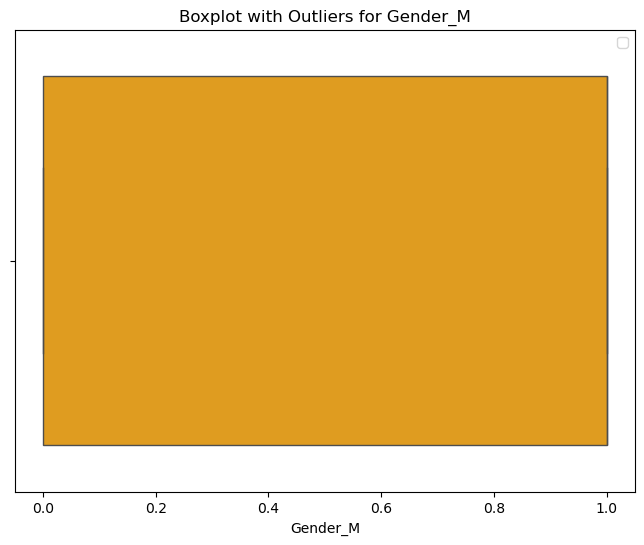

Column: Medical Fee Region freq - Number of Outliers: 0
Column: Medical Fee Region freq - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


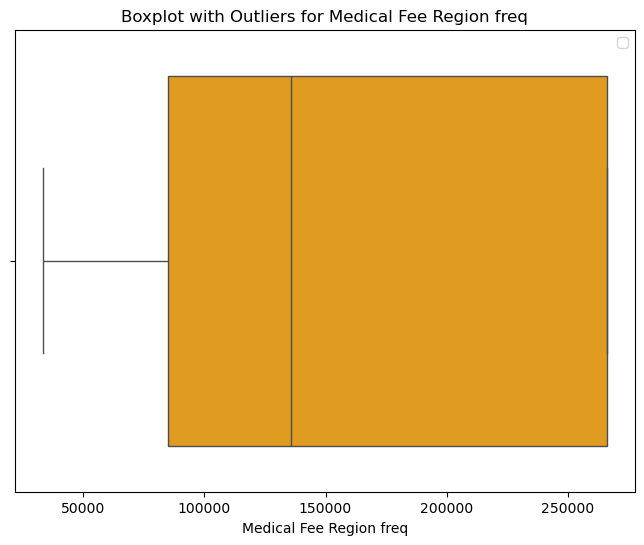

Column: Accident Date Year - Number of Outliers: 3898
Column: Accident Date Year - % of Outliers: 0.85% 



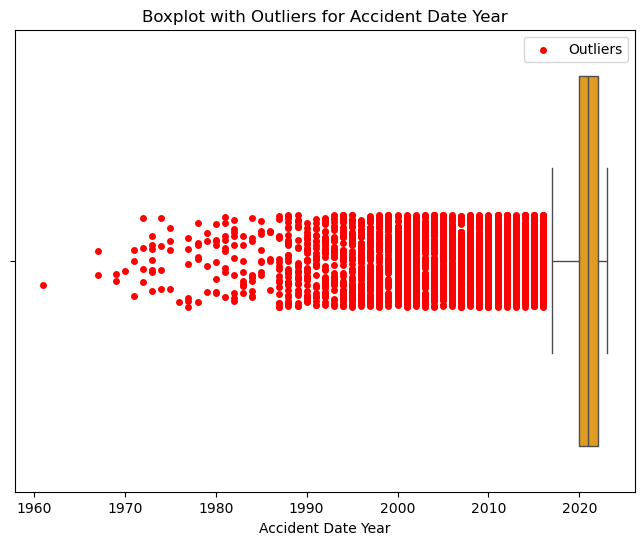

Column: Accident Date Month - Number of Outliers: 0
Column: Accident Date Month - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


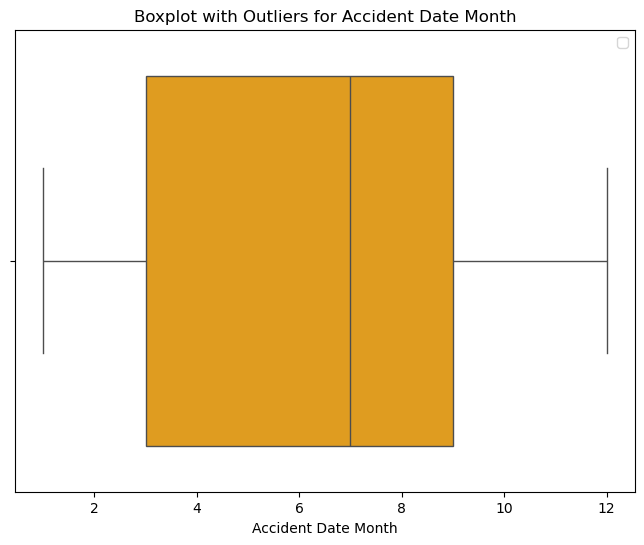

Column: Accident Date Day - Number of Outliers: 0
Column: Accident Date Day - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


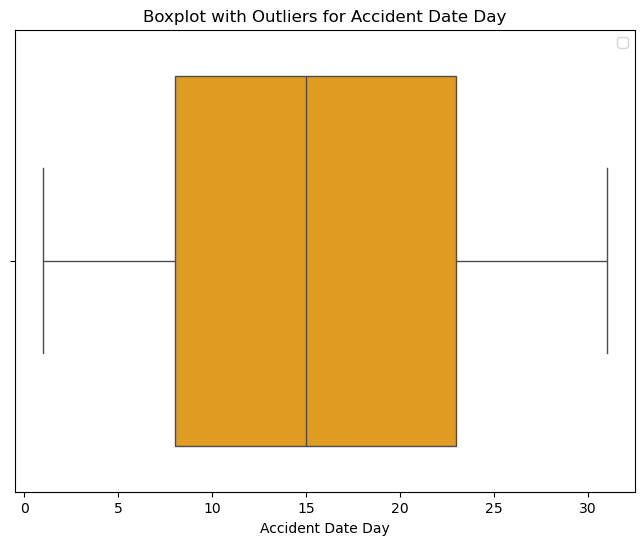

Column: Accident Date Day of Week - Number of Outliers: 0
Column: Accident Date Day of Week - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


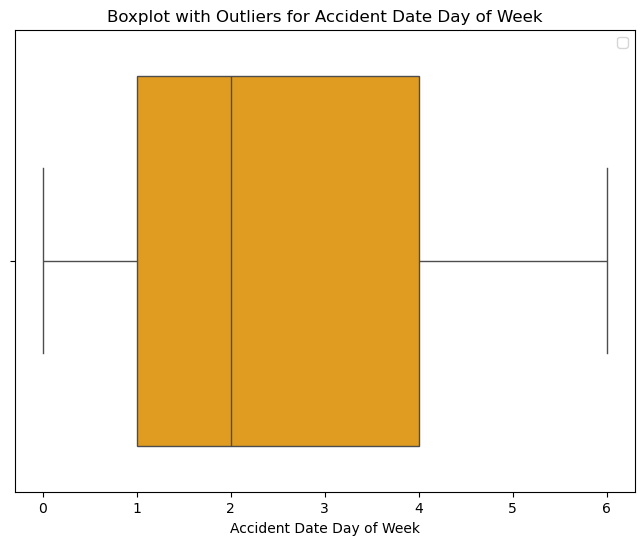

Column: Assembly Date Year - Number of Outliers: 0
Column: Assembly Date Year - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


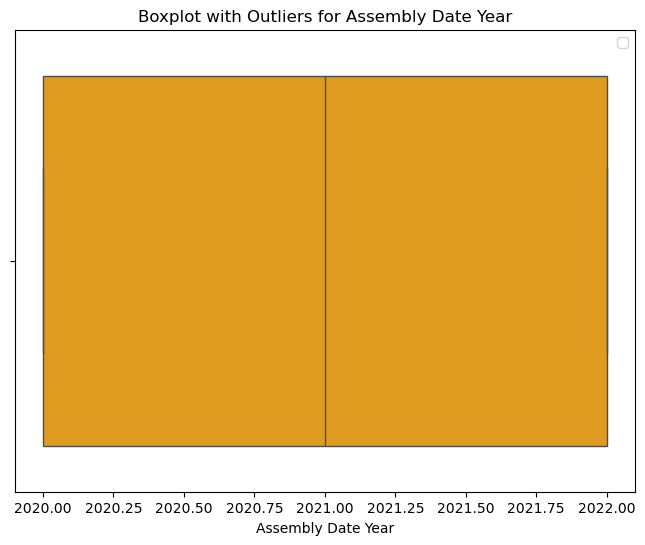

Column: Assembly Date Month - Number of Outliers: 0
Column: Assembly Date Month - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


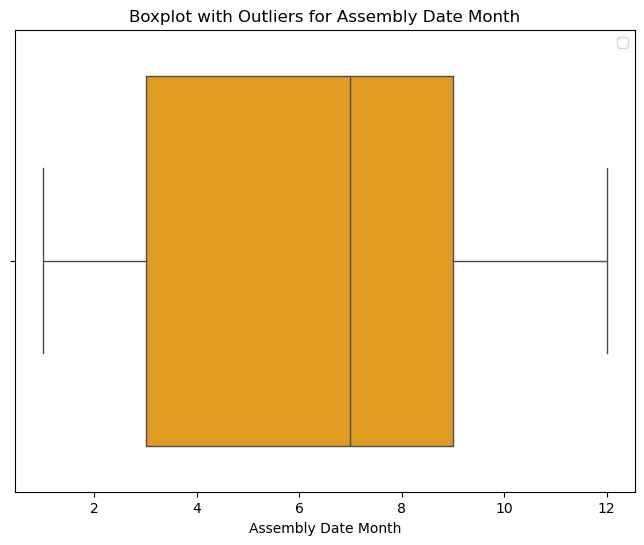

Column: Assembly Date Day - Number of Outliers: 0
Column: Assembly Date Day - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


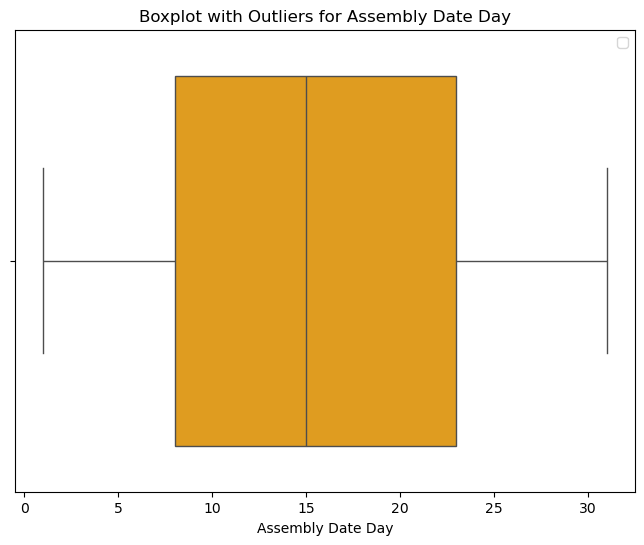

Column: Assembly Date Day of Week - Number of Outliers: 0
Column: Assembly Date Day of Week - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


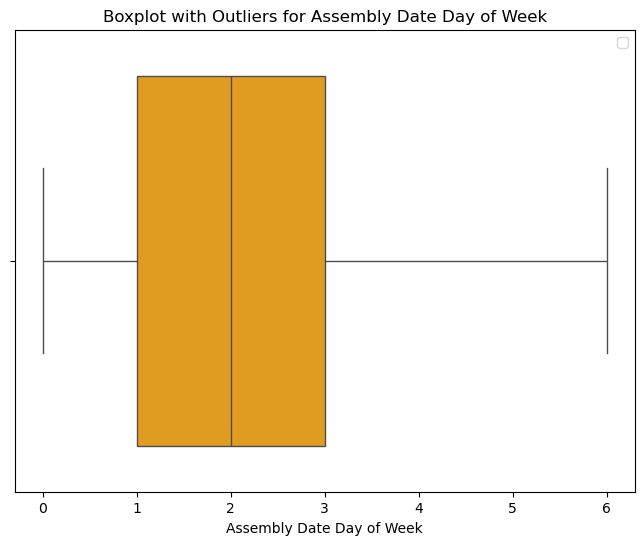

Column: C-2 Date Year - Number of Outliers: 970
Column: C-2 Date Year - % of Outliers: 0.21% 



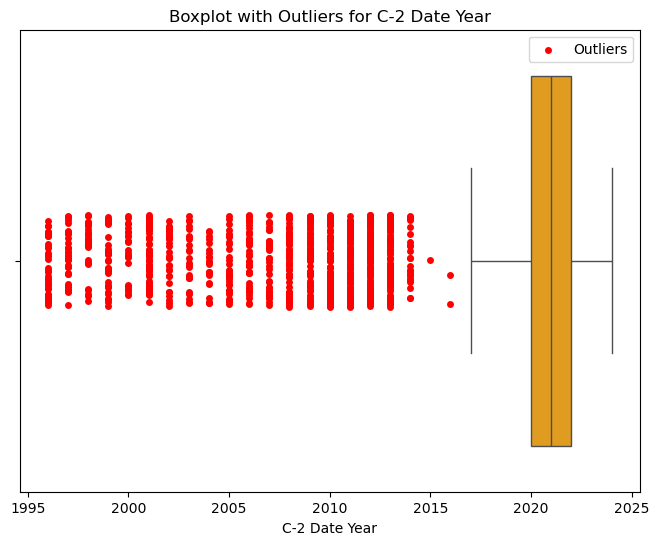

Column: C-2 Date Month - Number of Outliers: 0
Column: C-2 Date Month - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


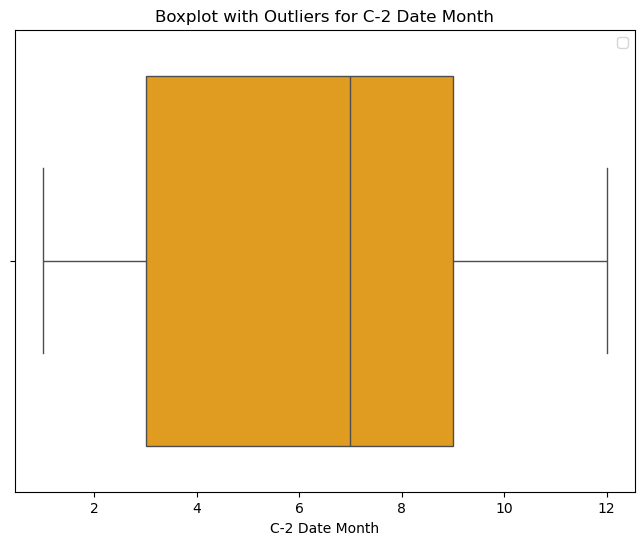

Column: C-2 Date Day - Number of Outliers: 0
Column: C-2 Date Day - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


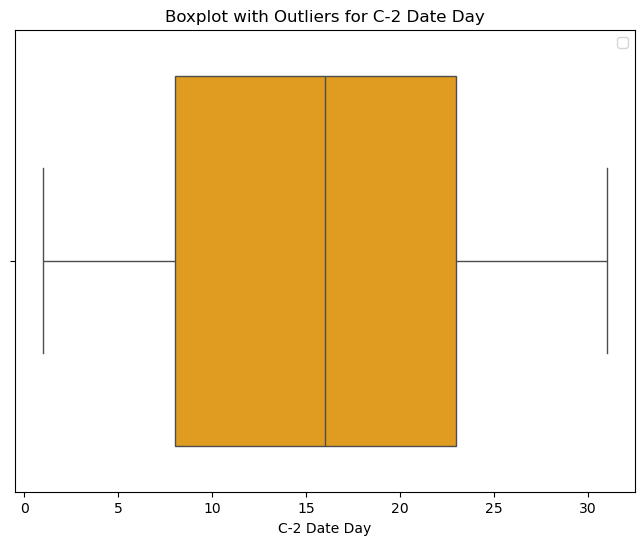

Column: C-2 Date Day of Week - Number of Outliers: 0
Column: C-2 Date Day of Week - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


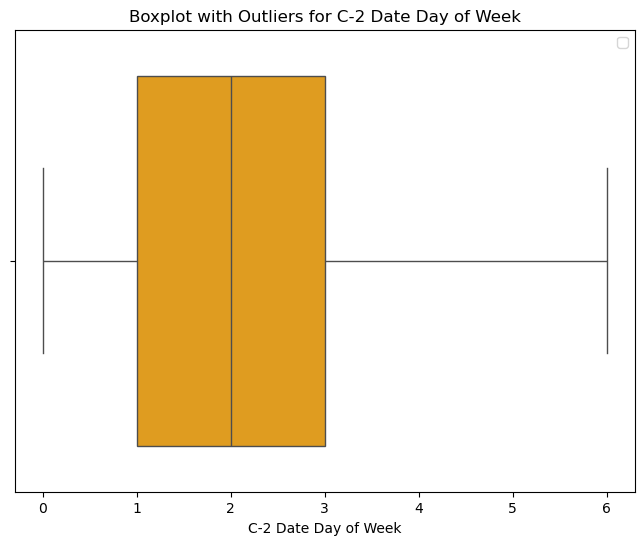

Column: WCIO Codes - Number of Outliers: 0
Column: WCIO Codes - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


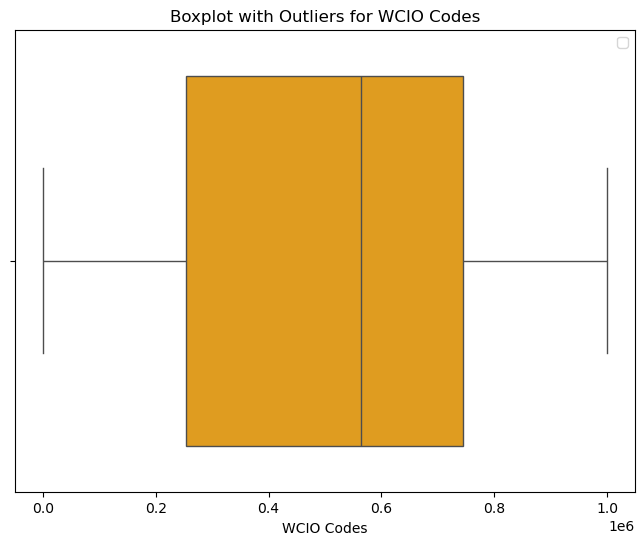

Column: Insurance - Number of Outliers: 0
Column: Insurance - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


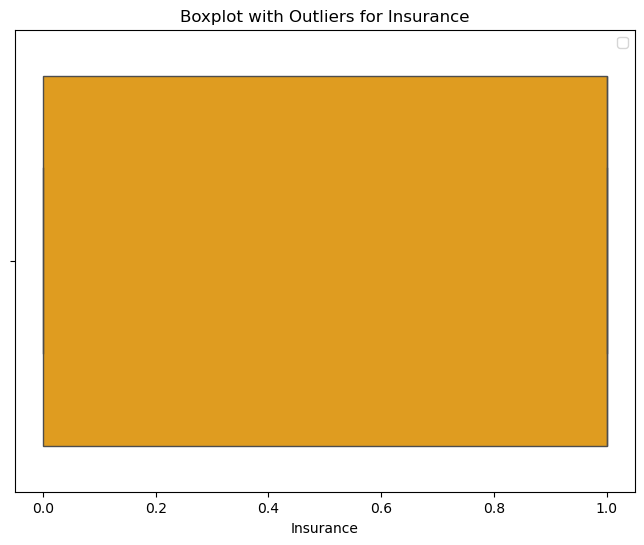

Column: Zip Code Valid - Number of Outliers: 35126
Column: Zip Code Valid - % of Outliers: 7.65% 



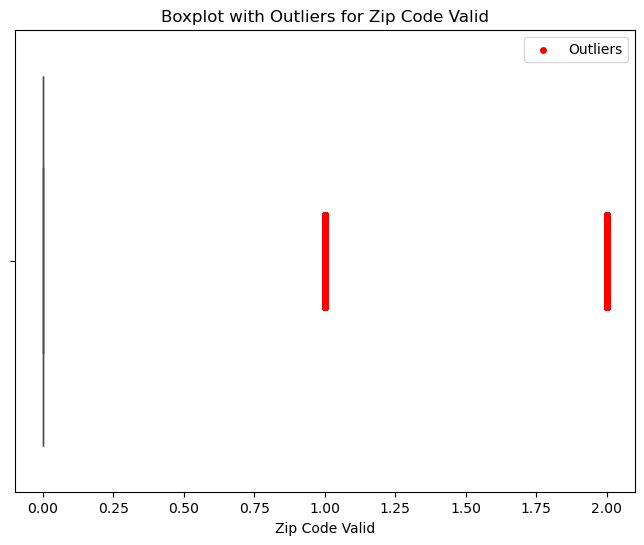

Column: Industry Sector Count Enc - Number of Outliers: 0
Column: Industry Sector Count Enc - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


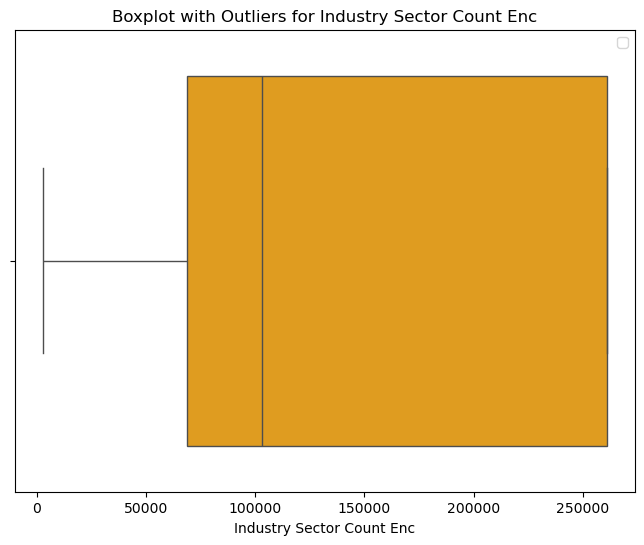

Column: Age Group - Number of Outliers: 26124
Column: Age Group - % of Outliers: 5.69% 



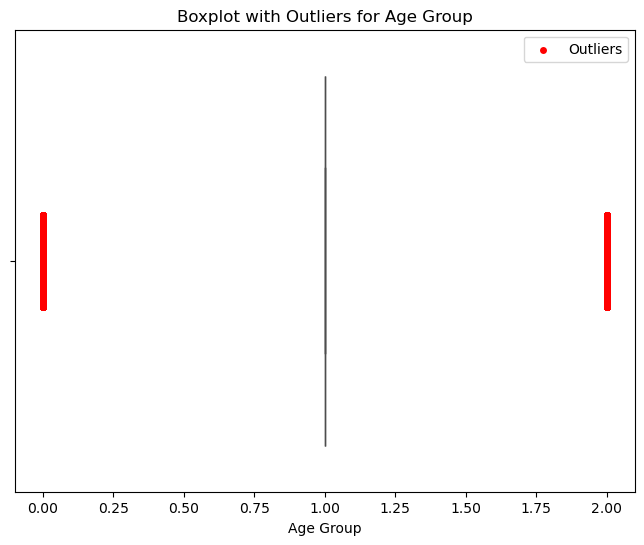

Column: C-3 Date Binary - Number of Outliers: 0
Column: C-3 Date Binary - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


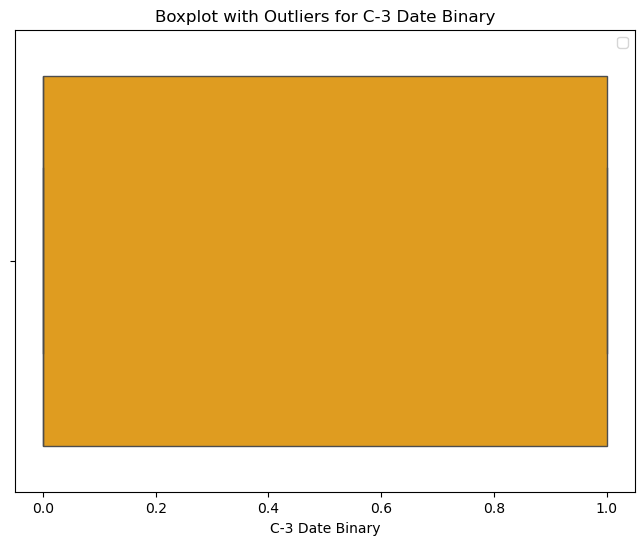

Column: First Hearing Date Binary - Number of Outliers: 0
Column: First Hearing Date Binary - % of Outliers: 0.00% 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


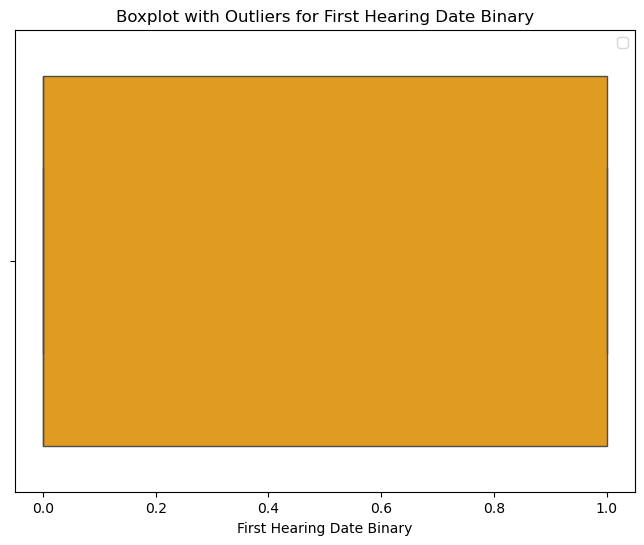

Columns with more than 0.0001% Outliers:
['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Industry Code', 'WCIO Part Of Body Code', 'Alternative Dispute Resolution Bin', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'COVID-19 Indicator Enc', 'Accident Date Year', 'C-2 Date Year', 'Zip Code Valid', 'Age Group']


{'Age at Injury': {'lower_bound': -3.5, 'upper_bound': 88.5},
 'Average Weekly Wage': {'lower_bound': -1265.01, 'upper_bound': 2108.35},
 'Birth Year': {'lower_bound': 1930.0, 'upper_bound': 2026.0},
 'IME-4 Count': {'lower_bound': 0.0, 'upper_bound': 0.0},
 'Industry Code': {'lower_bound': 17.0, 'upper_bound': 89.0},
 'WCIO Cause of Injury Code': {'lower_bound': -40.0, 'upper_bound': 144.0},
 'WCIO Nature of Injury Code': {'lower_bound': -53.0, 'upper_bound': 115.0},
 'WCIO Part Of Body Code': {'lower_bound': 0.5, 'upper_bound': 84.5},
 'Number of Dependents': {'lower_bound': -5.0, 'upper_bound': 11.0},
 'Alternative Dispute Resolution Bin': {'lower_bound': 0.0,
  'upper_bound': 0.0},
 'Attorney/Representative Bin': {'lower_bound': -1.5, 'upper_bound': 2.5},
 'Carrier Name Enc': {'lower_bound': -536.0, 'upper_bound': 2112.0},
 'Carrier Type freq': {'lower_bound': -150190.5, 'upper_bound': 546701.5},
 'Carrier Type_1A. PRIVATE': {'lower_bound': -1.5, 'upper_bound': 2.5},
 'Carrier Type

In [93]:
p.detect_outliers_iqr(X_train, 0.0001)

## Dealing With Outliers

Here we will apply some techniques to attempt to deal with outliers, either by applying some transformations or removing them. Our goal is to not remove more than 5% of observations. To keep track of this metrics, we will start by saving the initial length of the dataset.

In [94]:
X_train_copy = X_train.copy()
X_train_len = len(X_train_copy)

In [95]:
X_train

,Age at Injury,Average Weekly Wage,Birth Year,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Alternative Dispute Resolution Bin,Attorney/Representative Bin,Carrier Name Enc,Carrier Type freq,Carrier Type_1A. PRIVATE,Carrier Type_2A. SIF,Carrier Type_3A. SELF PUBLIC,Carrier Type_4A. SELF PRIVATE,County of Injury freq,COVID-19 Indicator Enc,District Name freq,Gender Enc,Gender_F,Gender_M,Medical Fee Region freq,Accident Date Year,Accident Date Month,Accident Date Day,Accident Date Day of Week,Assembly Date Year,Assembly Date Month,Assembly Date Day,Assembly Date Day of Week,C-2 Date Year,C-2 Date Month,C-2 Date Day,C-2 Date Day of Week,WCIO Codes,Insurance,Zip Code Valid,Industry Sector Count Enc,Age Group,C-3 Date Binary,First Hearing Date Binary
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5785935,49.0,744.06,1971.0,2.0,31.0,29,59,42,6.0,0,1,639,285367,1,0,0,0,58333,0,270778,1,1,0,265981,2021.0,8.0,5.0,3.0,2021,8,10,1,2021.0,8.0,10.0,1.0,295942,0,0,69053,1,1,0
5980545,31.0,1157.33,1991.0,0.0,62.0,99,1,9,2.0,0,0,409,121920,0,0,1,0,39618,0,270778,1,1,0,265981,2022.0,4.0,5.0,1.0,2022,5,2,0,2022.0,4.0,30.0,5.0,9919,0,0,260939,1,0,1
5552635,44.0,0.00,1976.0,0.0,49.0,80,52,56,3.0,0,0,906,285367,1,0,0,0,53207,0,270778,0,0,1,265981,2020.0,9.0,1.0,1.0,2020,9,4,4,2020.0,9.0,4.0,4.0,805256,1,0,54023,1,0,0
5758039,25.0,0.00,1996.0,0.0,44.0,68,10,11,1.0,0,0,80,52788,0,0,0,1,53207,0,270778,0,0,1,265981,2021.0,6.0,10.0,3.0,2021,7,2,4,2021.0,7.0,2.0,4.0,681011,0,0,103330,1,0,0
5951382,41.0,250.00,1980.0,0.0,48.0,45,49,9,4.0,0,1,48,52788,0,0,0,1,43580,0,270778,0,0,1,265981,2022.0,1.0,26.0,2.0,2022,3,25,4,2022.0,3.0,30.0,2.0,45499,0,0,54023,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5837651,26.0,1244.56,1995.0,1.0,62.0,98,80,41,6.0,0,1,689,285367,1,0,0,0,25754,0,270778,0,0,1,53654,2021.0,10.0,15.0,4.0,2021,10,19,1,2021.0,10.0,19.0,1.0,988041,1,0,260939,1,1,1
5781926,55.0,969.26,1966.0,7.0,62.0,74,10,90,1.0,0,1,251,285367,1,0,0,0,58333,0,270778,0,0,1,265981,2021.0,7.0,28.0,2.0,2021,8,4,2,2021.0,8.0,4.0,2.0,741090,0,0,260939,1,1,1
5890060,57.0,794.09,1964.0,0.0,81.0,53,52,53,5.0,0,0,764,285367,1,0,0,0,30874,0,45605,1,1,0,135885,2021.0,11.0,11.0,3.0,2022,1,4,1,2022.0,1.0,4.0,1.0,535253,1,0,23106,1,0,0


**Average Weekly Wage**

In [96]:
# Calculate the 1st and 99th percentiles
lower_bound = X_train['Average Weekly Wage'].quantile(0.01)
upper_bound = X_train['Average Weekly Wage'].quantile(0.99)

# Clip values to these bounds
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].clip(lower=lower_bound, upper=upper_bound)

# Apply log1p transformation to reduce skewness
X_train['Average Weekly Wage Log'] = np.log1p(X_train['Average Weekly Wage'])

**Birth Year**

In [97]:
# Calculate the number of dropped rows based on a consistent threshold
dropped_len_birth_year = len(X_train[X_train['Birth Year'] < 1930])

# Clip Birth Year to a valid range
X_train['Birth Year'] = X_train['Birth Year'].clip(lower=1930, upper=2023)

**IME-4 Count**

In [98]:
# Log transform the data first
X_train['IME-4 Count Log'] = np.log1p(X_train['IME-4 Count'])

# Apply Power Transformation for further normalization
pt = PowerTransformer(method='yeo-johnson')
X_train['IME-4 Count Transformed'] = pt.fit_transform(X_train[['IME-4 Count Log']])

# Check final skewness
print("Final Skewness:", X_train['IME-4 Count Transformed'].skew())

Final Skewness: 1.2788130385955767


**Alternative Dispute Resolution Bin**

In [99]:
# Fill missing values with 0 (assuming NaN means no dispute resolution)
X_train['Alternative Dispute Resolution Bin'] = X_train['Alternative Dispute Resolution Bin'].fillna(0).astype(int)

**Covid-19 Indicator Enc**

In [100]:
# Fill missing values with 0, assuming NaN means "not related to COVID-19"
X_train['COVID-19 Indicator Enc'] = X_train['COVID-19 Indicator Enc'].fillna(0).astype(int)

In [101]:
print(X_train['COVID-19 Indicator Enc'].value_counts(normalize=True))

COVID-19 Indicator Enc
0    0.951884
1    0.048116
Name: proportion, dtype: float64


**Accident Date Year**

In [102]:
# Clip years to a valid range
X_train['Accident Date Year'] = X_train['Accident Date Year'].clip(lower=2000, upper=2023)
X_train['C-2 Date Year'] = X_train['C-2 Date Year'].clip(lower=2000, upper=2023)

# Calculate year differences
X_train['Accident Date Year Diff'] = 2023 - X_train['Accident Date Year']
X_train['C-2 Date Year Diff'] = 2023 - X_train['C-2 Date Year']

In [103]:
# Check for outliers in the new features
print(X_train['Accident Date Year Diff'].describe())
print(X_train['C-2 Date Year Diff'].describe())

count    456261.000000
mean          2.158977
std           1.654217
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          23.000000
Name: Accident Date Year Diff, dtype: float64
count    447630.000000
mean          1.954407
std           1.061574
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          23.000000
Name: C-2 Date Year Diff, dtype: float64


**C-2 Date Year**

In [ ]:
dropped_len_c2_year =len(X_train[X_train['C-2 Date Year'] < 2017])

X_train = X_train[X_train['C-2 Date Year'] >= 2017]

**WCIO Part Of Body Code: Cap or bin outliers**

In [ ]:
X_train['WCIO Part Of Body Code'] = X_train['WCIO Part Of Body Code'].apply(
    lambda x: x if x <= 83 else 'Other'
)

**Agreement Reached: Ensure binary values**

In [ ]:
X_train['Agreement Reached'] = X_train['Agreement Reached'].apply(
    lambda x: 1 if x > 0 else 0
)

**Age at Injury: Restrict to reasonable range**

In [ ]:
X_train['Age at Injury'] = X_train['Age at Injury'].clip(lower=0, upper=90)

**Assess Decisions**

Since we dropped less than 5% of observations, we can continue to feature selection

In [ ]:
len_dropped = dropped_len_wage + dropped_len_birth_year + dropped_len_alt_disp + dropped_len_accident_year + dropped_len_c2_year 

len_dropped / X_train_len

**Ensure y_train has the same indices as X_train**

In [ ]:
common_indices = y_train.intersection(X_train.index)
y_train = y_train.intersection(common_indices)

**Winsorization for 'Average Weekly Wage'**

In [ ]:
upper_limit = X_train['Average Weekly Wage'].quantile(0.99)
lower_limit = X_train['Average Weekly Wage'].quantile(0.01)
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].clip(lower=lower_limit, upper=upper_limit)

**Transformations**

In [ ]:
# Log transformation for 'IME-4 Count'
X_train['IME-4 Count Log'] = np.log1p(X_train['IME-4 Count'])

# Square root transformation for another example
X_train['Average Weekly Wage Sqrt'] = np.sqrt(X_train['Average Weekly Wage'])

**Isolation Forest**

In [ ]:
# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.005, random_state=42)
outliers = iso_forest.fit_predict(X_train)

# Filter out the outliers (-1 indicates outlier)
X_train = X_train[outliers == 1]

**Domain-Specific Thresholds**

In [ ]:
# Remove unrealistic 'Birth Year' values
X_train = X_train[(X_train['Birth Year'] > 1900) & (X_train['Birth Year'] <= 2023)]

# Cap 'Average Weekly Wage' at a realistic maximum
X_train = X_train[X_train['Average Weekly Wage'] <= 5000]

**Clustering-Based Filtering**

In [ ]:
# Scale data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)

# Filter noise points (-1 indicates noise)
X_train = X_train[clusters != -1]

**Logarithmic Transformation with log1p**

In [ ]:
# Apply log1p transformation for skewed numeric features
X_train['Industry Code Log'] = np.log1p(X_train['Industry Code'])
X_train['WCIO Part Of Body Code Log'] = np.log1p(X_train['WCIO Part Of Body Code'])

### Logarithmic Transformation (log1p):

Use if the data is heavily skewed with a long tail (e.g., Industry Code).

Preserves the relative differences between values.

**Standard Scaling**

In [ ]:
# Apply scaling on 'Industry Code', 'WCIO Part Of Body Code'
X_train[['Industry Code Scaled', 'WCIO Part Of Body Code Scaled']] = scaler.fit_transform(
    X_train[['Industry Code', 'WCIO Part Of Body Code']]
)

### Standard Scaling:

Use when the feature needs to be standardized (mean = 0, variance = 1) for machine learning models sensitive to feature scaling (e.g., SVMs, KNN).

**Handling Categorical Outliers**

In [ ]:
# Example: Group rare 'Carrier Name' categories
top_carriers = X_train['Carrier Name'].value_counts().nlargest(10).index
X_train['Carrier Name'] = X_train['Carrier Name'].apply(
    lambda x: x if x in top_carriers else 'Other'
)

**Handle Missing Values District Name**

In [ ]:
X_train['District Name'] = X_train['District Name'].fillna('Unknown')

**One-Hot Encoding**

In [ ]:
X_train = pd.get_dummies(X_train, columns=['Gender', 'Carrier Type'], drop_first=True)

**Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train['District Name'] = le.fit_transform(X_train['District Name'])

**Frequency Encoding**

In [ ]:
freq_map = X_train['Carrier Name'].value_counts().to_dict()
X_train['Carrier Name'] = X_train['Carrier Name'].map(freq_map)

**Target Encoding**

In [ ]:
target_mean = X_train.groupby('Carrier Name')['Target'].mean()
X_train['Carrier Name Enc'] = X_train['Carrier Name'].map(target_mean)

### Check Changes

Average Weekly Wage - Outliers Before: 17711, Outliers After: 17711
Average Weekly Wage - Bounds Before: [-1265.01, 2108.35]
Average Weekly Wage - Bounds After: [-1265.01, 2108.35]


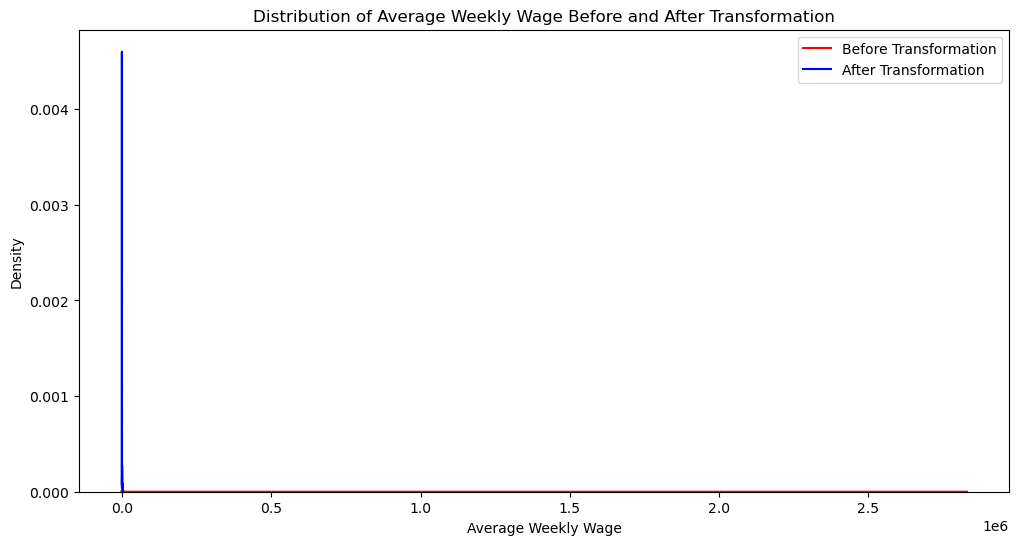

Birth Year - Outliers Before: 498, Outliers After: 0
Birth Year - Bounds Before: [1930.0, 2026.0]
Birth Year - Bounds After: [1930.0, 2026.0]


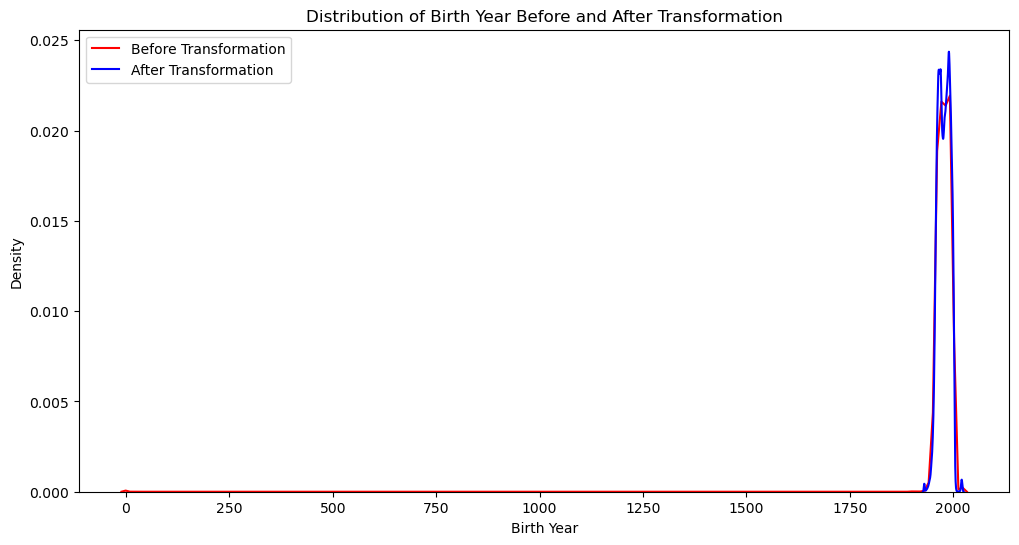

IME-4 Count - Outliers Before: 106210, Outliers After: 106210
IME-4 Count - Bounds Before: [0.0, 0.0]
IME-4 Count - Bounds After: [0.0, 0.0]


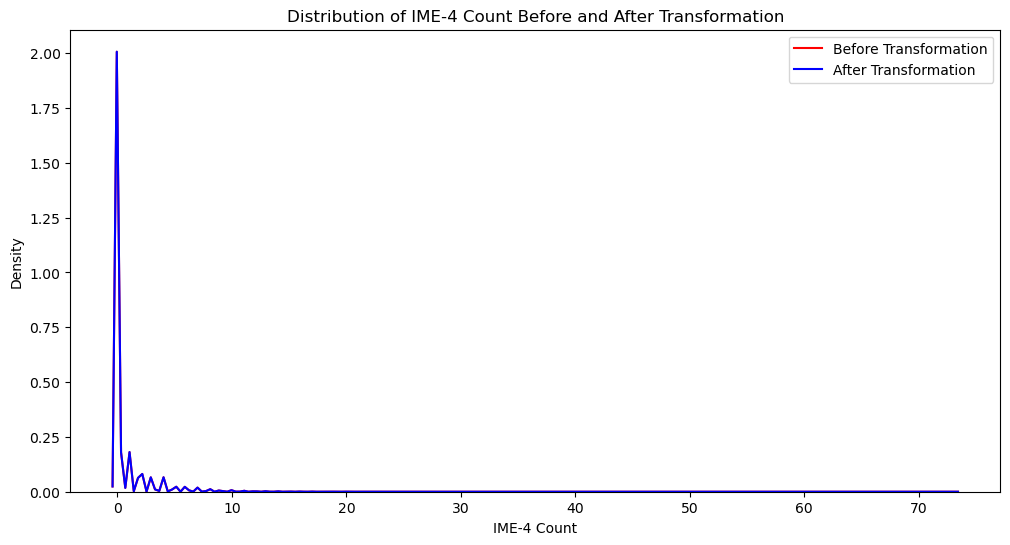

Alternative Dispute Resolution Bin - Outliers Before: 2073, Outliers After: 2073
Alternative Dispute Resolution Bin - Bounds Before: [0.0, 0.0]
Alternative Dispute Resolution Bin - Bounds After: [0.0, 0.0]


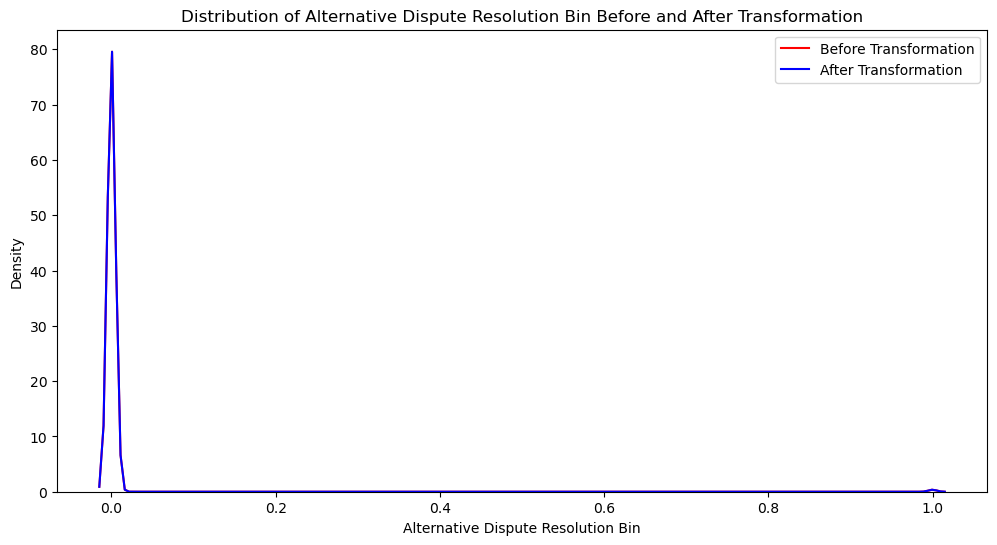

KeyError: 'Covid-19 Indicator Enc'

In [104]:
# Define the function to detect outliers using IQR
def check_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_below = (df[column] < lower_bound).sum()
    outliers_above = (df[column] > upper_bound).sum()
    total_outliers = outliers_below + outliers_above
    return total_outliers, lower_bound, upper_bound

# Function to display comparison
def compare_outliers_before_after(before, after, column_name):
    before_outliers, before_lower, before_upper = check_outliers(before, column_name)
    after_outliers, after_lower, after_upper = check_outliers(after, column_name)
    print(f"{column_name} - Outliers Before: {before_outliers}, Outliers After: {after_outliers}")
    print(f"{column_name} - Bounds Before: [{before_lower}, {before_upper}]")
    print(f"{column_name} - Bounds After: [{after_lower}, {after_upper}]")

# Function to plot before and after transformations
def plot_comparison(before, after, column_name):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(before[column_name], label='Before Transformation', color='red')
    sns.kdeplot(after[column_name], label='After Transformation', color='blue')
    plt.title(f'Distribution of {column_name} Before and After Transformation')
    plt.legend()
    plt.show()

# Apply and compare for all relevant columns
columns_to_check = [
    'Average Weekly Wage',
    'Birth Year',
    'IME-4 Count',
    'Alternative Dispute Resolution Bin',
    'Covid-19 Indicator Enc',
    'Accident Date Year Diff',
    'C-2 Date Year Diff',
    'WCIO Part Of Body Code'
]

for column in columns_to_check:
    compare_outliers_before_after(X_train_copy, X_train, column)
    plot_comparison(X_train_copy, X_train, column)

# 4. Feature Selection

<a href="#top">Top &#129033;</a>

In this section we will perform feature selection. We will start by splitting data into numeric, categorical or max 3 classes. Then, scaling will be applied. However, from the previous delivery we noted that the best performing models are Tree-Based, which are not sensitive to feature's scale, and therefore do not require scaling. Consequently, we will implement the same method for both scaled and unscaled numerical data, and compare the results.

In [ ]:
X_train

**Variable type split**

In [ ]:
num = ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents',
       'Accident Date Year', 'Accident Date Month', 'Accident Date Day', 'Assembly Date Year', 
       'Assembly Date Month', 'Assembly Date Day', 'C-2 Date Year', 'C-2 Date Month', 'C-2 Date Day',
       'IME-4 Count Log', 'IME-4 Count Double Log']

max3_class = ['Attorney/Representative Bin', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF',
              'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'COVID-19 Indicator Enc',
              'Gender Enc', 'Gender_F', 'Gender_M', 'Zip Code Valid', 'Age Group', 'C-3 Date Binary',
              'First Hearing Date Binary']

categ = ['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
         'WCIO Part Of Body Code', 'Carrier Name Enc', 'Carrier Type freq', 'County of Injury freq',
         'District Name freq', 'Medical Fee Region freq', 'Accident Date Day of Week', 'Assembly Date Day of Week',
         'C-2 Date Day of Week', 'WCIO Codes', 'Industry Sector Count Enc']

**Scaling**

In [ ]:
robust = RobustScaler()

In [ ]:
# Scaling the numerical features in the training set using RobustScaler
X_train_num_RS = robust.fit_transform(X_train[num])
X_train_num_RS = pd.DataFrame(X_train_num_RS, columns=num, index=X_train.index)

In [ ]:
# Scaling the numerical features in the validation set using the fitted RobustScaler
X_val_num_RS = robust.transform(X_val[num])
X_val_num_RS = pd.DataFrame(X_val_num_RS, columns=num, index=X_val.index)

# Scaling the numerical features in the test set using the same fitted RobustScaler
test_num_RS = robust.transform(test[num])
test_num_RS = pd.DataFrame(test_num_RS, columns=num, index=test.index)

In [ ]:
X_train_all_categ = pd.concat([X_train[categ], X_train[max3_class]], axis=1)
X_val_all_categ = pd.concat([X_val[categ], X_val[max3_class]], axis=1)

## 4.1 Filter-Based Methods

<a href="#top">Top &#129033;</a>

Filter-based methods evaluate the relevance of features independently of the model using statistical measures like correlation, Chi-square tests, and mutual information. This section explores how these methods help reduce dimensionality, improve model performance, and prevent overfitting by selecting the most informative features.



**Variance Threshold**

In [ ]:
X_train.var()

In [ ]:
threshold = 0.1

# Initialize the VarianceThreshold selector with the specified threshold
selector = VarianceThreshold(threshold=threshold)

# Apply the selector to the scaled training data (X_train_RS) to retain only the high-variance features
X_train_high_variance = selector.fit_transform(X_train[num])

# Print the number of features before applying the variance threshold
print(f"Number of features before variance threshold: {X_train[num].shape[1]}")

# Print the number of features after applying the variance threshold
print(f"Number of features after variance threshold: {X_train_high_variance.shape[1]}")

**Spearman Correlation Matrix**

In [ ]:
# Visualize the correlation matrix to identify relationships between numerical features
fs.correlation_matrix(X_train[num])

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def chi_squared(X_categ, y, threshold=0.05):

    # Fit the chi-squared selector
    chi2_selector = SelectKBest(chi2, k='all')
    chi2_selector.fit(X_categ, y)

    # Get Chi-squared scores and p-values
    chi2_scores = chi2_selector.scores_
    p_values = chi2_selector.pvalues_

    # Create a DataFrame for scores and p-values
    scores_df = pd.DataFrame({
        'Feature': X_categ.columns,
        'Chi2 Score': chi2_scores,
        'p-value': p_values
    })

    # Filter features based on the p-value threshold
    selected_features = scores_df[scores_df['p-value'] < threshold]['Feature']
    
    # Extract non-selected features
    non_selected_features = scores_df[scores_df['p-value'] >= threshold]

    # Plot the Chi-squared scores
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Chi2 Score', y='Feature', data=scores_df.sort_values(by='Chi2 Score', ascending=False), color='orange')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'p-value Threshold = {threshold}')
    plt.title('Chi-squared Scores for Features')
    plt.xlabel('Chi-squared Score')
    plt.ylabel('Features')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nInitial Features: {len(X_categ.columns.tolist())}\n")
    print(X_categ.columns.tolist())
    print(f"\nDecision for Categorical Features (p-value < threshold): {len(selected_features.tolist())}\n")
    print(selected_features.tolist())

    # Display non-selected features with their p-values and Chi-squared scores
    print("\nNon-Selected Features (p-value >= threshold):\n")
    print(non_selected_features[['Feature', 'Chi2 Score', 'p-value']])


In [ ]:
chi_squared(X_train[categ], y_train)

## 4.2 Wrapper Methods

<a href="#top">Top &#129033;</a>

Unlike filter methods, which assess features independently, wrapper methods evaluate the effectiveness of feature subsets by measuring the model’s performance, making them more computationally expensive but often more accurate in selecting relevant features.

## 4.3 Embedded Methods

<a href="#top">Top &#129033;</a>

These methods use algorithms that inherently select features as part of the model’s learning process. Embedded methods are computationally efficient and tend to be more accurate than filter methods, as they consider feature interactions and model performance simultaneously.
